In [9]:
import pandas as pd #For reading dataset files
import networkx as nx #For network creation/analysis
from networkx.algorithms import community
import community as community_louvain
import matplotlib.pyplot as plt #For plotting graphs
import igraph as ig
import numpy as np
import leidenalg as la
from sklearn.metrics import (
    adjusted_rand_score,
    adjusted_mutual_info_score,
    normalized_mutual_info_score,
    homogeneity_score,
    completeness_score,
    f1_score,
    confusion_matrix,
)
from collections import Counter
from networkx.algorithms.community import label_propagation_communities
from cdlib import algorithms

from modularitydensity.metrics import modularity_density
import community as louvain
import leidenalg as la
from cdlib.algorithms import louvain

from cdlib import evaluation

import random

np.random.seed(42)
random.seed(42)

# Login dataset

Comunita_0: ['FloridaState', 'NorthCarolinaState', 'Virginia', 'GeorgiaTech', 'Duke', 'NorthCarolina', 'Clemson', 'WakeForest', 'Maryland']
Comunita_1: ['VirginiaTech', 'BostonCollege', 'WestVirginia', 'Syracuse', 'Pittsburgh', 'Temple', 'Rutgers', 'MiamiFlorida']
Comunita_2: ['Iowa', 'PennState', 'Northwestern', 'Wisconsin', 'Michigan', 'Purdue', 'OhioState', 'Minnesota', 'Illinois', 'MichiganState', 'Indiana']
Comunita_3: ['KansasState', 'TexasTech', 'Baylor', 'Colorado', 'Kansas', 'IowaState', 'Nebraska', 'TexasA&M', 'Oklahoma', 'Texas', 'Missouri', 'OklahomaState']
Comunita_4: ['EastCarolina', 'Houston', 'Louisville', 'Memphis', 'SouthernMississippi', 'Tulane', 'Army', 'Cincinnati', 'TexasChristian', 'AlabamaBirmingham']
Comunita_5: ['CentralFlorida', 'Connecticut', 'Navy', 'NotreDame', 'UtahState']
Comunita_6: ['NorthernIllinois', 'WesternMichigan', 'Akron', 'BallState', 'BowlingGreenState', 'Buffalo', 'CentralMichigan', 'EasternMichigan', 'Kent', 'MiamiOhio', 'Ohio', 'Toledo', 'M

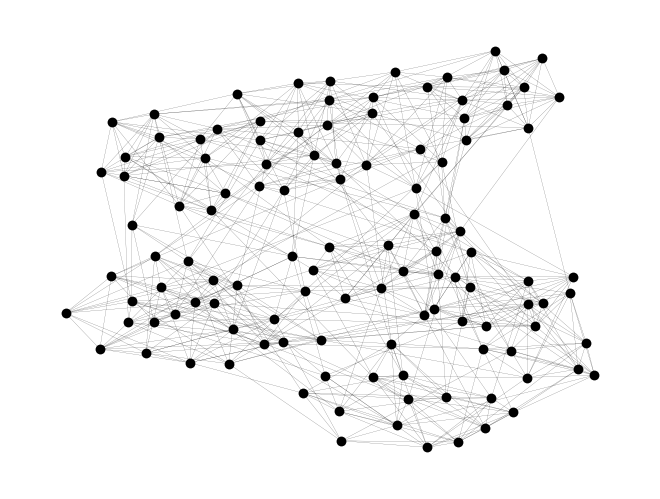

In [10]:
# Percorso del file GML
file_path = "C:/Users/lulyd/Downloads/football/football.gml"

# Leggi il grafo dal file GML
G = nx.read_gml(file_path)

communities={
    'Comunita_0': [1, 25, 33, 37, 45, 89, 103, 105, 109],
    'Comunita_1': [19, 29, 30, 35, 55, 79, 94, 101],
    'Comunita_2': [2, 6, 13, 15, 32, 39, 47, 60, 64, 100, 106],
    'Comunita_3': [3, 5, 10, 40, 52, 72, 74, 81, 84, 98, 102, 107],
    'Comunita_4': [44, 48, 57, 66, 75, 86, 91, 92, 110, 112],
    'Comunita_5': [36, 42, 80, 82, 90],
    'Comunita_6': [12, 14, 18, 26, 31, 34, 38, 43, 54, 61, 71, 85, 99],
    'Comunita_7': [0, 4, 9, 16, 23, 41, 93, 104],
    'Comunita_8': [7, 8, 21, 22, 51, 68, 77, 78, 108, 111],
    'Comunita_9': [17, 20, 27, 56, 62, 65, 70, 76, 87, 95, 96, 113],
    'Comunita_10': [11, 24, 50, 59, 63, 69, 97],
    'Comunita_11': [28, 46, 49, 53, 58, 67, 73, 83, 88, 114]
    }

def get_communities_as_lists(communities, G):
    node_list = list(G.nodes)
    community_lists = {name: [] for name in communities.keys()}

    for name, ids in communities.items():
        for id in ids:
            if id < len(node_list):
                community_lists[name].append(node_list[id])

    return community_lists

# Esegui la sostituzione
community_lists = get_communities_as_lists(communities, G)

# Stampa il risultato
for name, members in community_lists.items():
    print(f"{name}:", members)

# Disegna il grafo con una disposizione migliore
pos = nx.spring_layout(G, k=1)  # Aumenta k per maggiore spaziatura



# Inizializza un dizionario per le comunità, includendo la comunità 0
communities = {i: [] for i in range(12)}  # crea comunità da 0 a 11

options = {"node_color": "black", "node_size": 50, "linewidths": 0, "width": 0.1}

pos = nx.spring_layout(G, seed=1969)  # Seed for reproducible layout
nx.draw(G, pos, **options)
plt.show()

In [11]:
def calcola_metriche(comunita_attese, comunita_rilevate, adjacency_matrix):
    # Creazione della mappatura dei nodi a indici
    nodi = []
    for community in comunita_attese.values():
        nodi.extend(community)
    nodo_to_index = {nodo: idx for idx, nodo in enumerate(nodi)}

    # Preparazione dei dati per ARI e NMI
    true_labels = np.zeros(len(nodi), dtype=int)  # Etichette vere
    for community_id, community_nodes in comunita_attese.items():
        for node in community_nodes:
            true_labels[nodo_to_index[node]] = int(community_id[-1])  # Usa l'ID della comunità

    predicted_labels = np.full(len(nodi), -1)  # Valori non assegnati    
    for cluster_id, nodes in comunita_rilevate.items():
        for node in nodes:
            if node in nodo_to_index:  # Assicurati che il nodo esista nella mappatura
                predicted_labels[nodo_to_index[node]] = int(cluster_id)  # Usa l'ID della comunità

# Calcolo delle metriche
    ari = adjusted_rand_score(true_labels, predicted_labels)
    ami = adjusted_mutual_info_score(true_labels, predicted_labels)
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)

    # Calcolo dell'HS
    hs = homogeneity_score(true_labels, predicted_labels)

    # Calcolo del CS
    cs = completeness_score(true_labels, predicted_labels)

    # Calcolo della F1 Score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Calcolo della Confusion Matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Calcolo della Modularity Density
    md = modularity_density(adjacency_matrix, comunita_rilevate, nodo_to_index)

    # Calcolo della Community Score
    cs_score = community_score(adjacency_matrix, comunita_rilevate, nodo_to_index)

    # Calcolo della Community Fitness
    fitness = community_fitness(adjacency_matrix, comunita_rilevate, nodo_to_index)


    # Stampa dei risultati
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Adjusted Mutual Information (AMI): {ami:.4f}")
    print(f"Homogeneity Score (HS): {hs:.4f}")
    print(f"Completeness Score (CS): {cs:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Modularity Density: {md:.4f}")
    print(f"Community Score: {cs_score:.4f}")
    print(f"Community Fitness: {fitness:.4f}")
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

    # Risultati da visualizzare
    metriche = {
        'ARI': ari,
        'AMI': ami,
        'HS': hs,
        'CS': cs,
        'F1 Score': f1,
        'Modularity Density': md,
        'Community Score': cs_score,
        'Community Fitness': fitness,
        'NMI': nmi
    }

    return metriche

    # Creazione del grafico a barre
    plt.figure(figsize=(10, 6))
    plt.bar(metriche.keys(), metriche.values(), color='skyblue')
    plt.ylabel('Valore')
    plt.title('Metriche di Rilevamento delle Comunità')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

 

    x = np.arange(len(labels))
    bar_width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - bar_width/2, true_values, width=bar_width, label='Comunità Attese', color='skyblue')
    plt.bar(x + bar_width/2, predicted_values, width=bar_width, label='Comunità Rilevate', color='salmon')
    plt.xlabel('Comunità')
    plt.ylabel('Numero di Nodi')
    plt.title('Confronto tra Comunità Attese e Rilevate')
    plt.xticks(x, labels)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    
# Funzioni di supporto 
def modularity_density(adjacency_matrix, comunita_rilevate, nodo_to_index):
    k = len(comunita_rilevate)  # Numero di comunità
    densita = 0.0  # Inizializza la densità a zero

    for community in comunita_rilevate.values():
        V_c = len(community)  # Numero di nodi nella comunità
        E_c = 0  # Inizializza il conteggio degli archi nella comunità

        # Calcola il numero di archi tra i nodi nella comunità
        for i in range(V_c):
            for j in range(i + 1, V_c):  # Evita il conteggio doppio
                idx_i = nodo_to_index[community[i]]
                idx_j = nodo_to_index[community[j]]
                if adjacency_matrix[idx_i, idx_j] > 0:
                    E_c += 1

        # Calcola la densità della comunità
        if V_c > 1:  # Evita divisioni per zero
            densita += E_c / (V_c * (V_c - 1))

    # Calcola la densità modulare finale
    if k > 0:  # Evita divisioni per zero
        densita_modulare = densita / k
    else:
        densita_modulare = 0

    return densita_modulare

def community_score(adjacency_matrix, comunita_rilevate, nodo_to_index):
    internal_edges = 0
    total_edges = 0
    num_nodes = adjacency_matrix.shape[0]

    for community in comunita_rilevate.values():
        for i in range(len(community)):
            for j in range(i + 1, len(community)):  # Per evitare il conteggio doppio
                node_i = community[i]
                node_j = community[j]
                if adjacency_matrix[nodo_to_index[node_i], nodo_to_index[node_j]] > 0:
                    internal_edges += 1
    
    # Conta anche gli archi totali nel grafo
    total_edges = np.sum(adjacency_matrix) / 2  # Dato che è una matrice simmetrica

    if total_edges == 0:
        return 0  # Evita divisioni per zero
    return internal_edges / total_edges


def community_fitness(adjacency_matrix, comunita_rilevate, nodo_to_index):
    internal_edges = 0
    external_edges = 0
    num_nodes = adjacency_matrix.shape[0]  # Assicurati che la matrice sia quadrata

    node_to_community = {}
    for community_id, nodes in comunita_rilevate.items():
        for node in nodes:
            node_to_community[node] = community_id

    for i in range(num_nodes):
        for j in range(num_nodes):
            if adjacency_matrix[i, j] > 0:  # Se esiste un arco
                node_i = list(nodo_to_index.keys())[list(nodo_to_index.values()).index(i)]
                node_j = list(nodo_to_index.keys())[list(nodo_to_index.values()).index(j)]
                if node_to_community.get(node_i) == node_to_community.get(node_j):  # Se appartengono alla stessa comunità
                    internal_edges += 1
                else:
                    external_edges += 1

    total_edges = internal_edges + external_edges

    # Evita divisioni per zero
    if total_edges == 0:
        return 0

    return internal_edges / total_edges

# Label propagation

Community 1: ['Arkansas', 'CentralFlorida', 'LouisianaLafayette', 'LouisianaMonroe', 'SouthCarolina', 'Tennessee', 'Florida', 'MiddleTennesseeState', 'Georgia', 'Kentucky', 'Auburn', 'MississippiState', 'Mississippi', 'LouisianaState', 'LouisianaTech', 'Vanderbilt', 'Alabama']
Community 2: ['OregonState', 'Stanford', 'ArkansasState', 'NewMexicoState', 'Arizona', 'BoiseState', 'Idaho', 'Oregon', 'California', 'Washington', 'ArizonaState', 'UCLA', 'UtahState', 'WashingtonState', 'SouthernCalifornia', 'NorthTexas']
Community 3: ['OklahomaState', 'TexasTech', 'Texas', 'IowaState', 'Missouri', 'Colorado', 'Nebraska', 'Kansas', 'Oklahoma', 'TexasA&M', 'KansasState', 'Baylor']
Community 4: ['OhioState', 'Michigan', 'Purdue', 'Illinois', 'Indiana', 'Minnesota', 'Wisconsin', 'MichiganState', 'PennState', 'Iowa', 'Northwestern']
Community 5: ['NotreDame', 'BostonCollege', 'Pittsburgh', 'MiamiFlorida', 'Temple', 'WestVirginia', 'Rutgers', 'Syracuse', 'VirginiaTech', 'Navy']
Community 6: ['Clemson

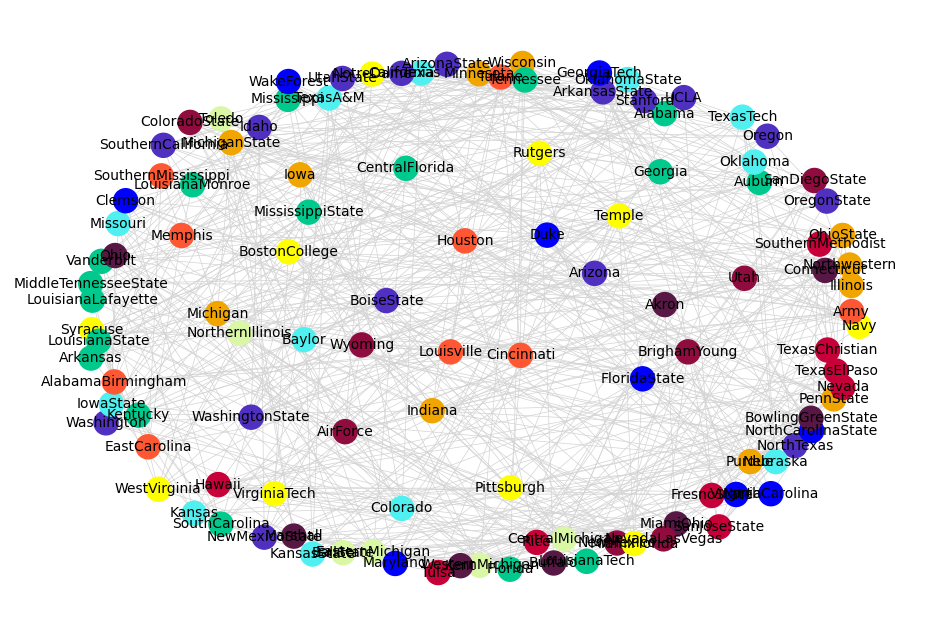

Adjusted Rand Index (ARI): 0.6515
Adjusted Mutual Information (AMI): 0.7748
Homogeneity Score (HS): 0.8380
Completeness Score (CS): 0.8027
F1 Score: 0.0345
Confusion Matrix:
[[ 3  4  0  0  0  9  0  0  0  0  0]
 [ 1  1  0  0  8  0  0  8  0  0  0]
 [ 0  0  0 11  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  9  1  0  0  0]
 [ 1  1  0  0  2  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  7  6]
 [ 0  0  0  0  0  0  0  0  8  0  0]
 [ 0 10  0  0  0  0  0  0  0  0  0]
 [12  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]]
Modularity Density: 0.0724
Community Score: 0.1370
Community Fitness: 0.1370
Normalized Mutual Information (NMI): 0.8199


In [12]:
community_graph = nx.Graph() 
# Rilevamento delle comunità con l'algoritmo Label Propagation
communities= algorithms.label_propagation(G).communities
community_dict_label_propagation = {i: community for i, community in enumerate(communities)}

for i, community in enumerate(communities):
    print(f"Community {i + 1}: {community}")

community_list=list(communities)


# Mappa ogni nodo alla sua comunità
node_to_community = {}
for i, community in enumerate(community_list):
    for node in community:
        node_to_community[node] = i


# Aggiungi gli archi tra le comunità se c'è una connessione tra nodi di comunità diverse
for u, v in G.edges():
    comm_u = node_to_community[u]
    comm_v = node_to_community[v]
    if comm_u != comm_v:
        community_graph.add_edge(comm_u, comm_v)

colors = ["#00C98D", "#5030C0", "#50F0F0", "#F0A500", 'yellow', 'blue', "#FF5733", "#C70039",  "#900C3F", "#581845", "#DAF7A6", "#FFC300"]

color_map_b = {}
keys = G.nodes()
values = "black"
for i in keys:
        color_map_b[i] = values
counter = 0
for c in community_list:
  for n in c:
    color_map_b[n] = colors[counter]
  counter = counter + 1

# Disegna il grafo originale con colori per le comunità
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=2)
nx.draw_networkx_edges(G, pos, width=0.5, edge_color='lightgray')  # Larghezza degli archi
nx.draw_networkx_nodes(G, pos, node_color=[color_map_b[node] for node in G.nodes()])
nx.draw_networkx_labels(G, pos, font_size=10)  # Dimensione delle etichette
plt.axis("off")
plt.show()

# Definisci le comunità attese come un dizionario
ground_truth_communities = {
    'Comunita_0': ['FloridaState', 'NorthCarolinaState', 'Virginia', 'GeorgiaTech', 'Duke', 'NorthCarolina', 'Clemson', 'WakeForest', 'Maryland'],
    'Comunita_1': ['VirginiaTech', 'BostonCollege', 'WestVirginia', 'Syracuse', 'Pittsburgh', 'Temple', 'Rutgers', 'MiamiFlorida'],
    'Comunita_2': ['Iowa', 'PennState', 'Northwestern', 'Wisconsin', 'Michigan', 'Purdue', 'OhioState', 'Minnesota', 'Illinois', 'MichiganState', 'Indiana'],
    'Comunita_3': ['KansasState', 'TexasTech', 'Baylor', 'Colorado', 'Kansas', 'IowaState', 'Nebraska', 'TexasA&M', 'Oklahoma', 'Texas', 'Missouri', 'OklahomaState'],
    'Comunita_4': ['EastCarolina', 'Houston', 'Louisville', 'Memphis', 'SouthernMississippi', 'Tulane', 'Army', 'Cincinnati', 'TexasChristian', 'AlabamaBirmingham'],
    'Comunita_5': ['CentralFlorida', 'Connecticut', 'Navy', 'NotreDame', 'UtahState'],
    'Comunita_6': ['NorthernIllinois', 'WesternMichigan', 'Akron', 'BallState', 'BowlingGreenState', 'Buffalo', 'CentralMichigan', 'EasternMichigan', 'Kent', 'MiamiOhio', 'Ohio', 'Toledo', 'Marshall'],
    'Comunita_7': ['BrighamYoung', 'NewMexico', 'SanDiegoState', 'Wyoming', 'Utah', 'ColoradoState', 'AirForce', 'NevadaLasVegas'],
    'Comunita_8': ['SouthernCalifornia', 'ArizonaState', 'UCLA', 'Arizona', 'Washington', 'Oregon', 'Stanford', 'WashingtonState', 'OregonState', 'California'],
    'Comunita_9': ['Auburn', 'Alabama', 'Florida', 'Kentucky', 'Vanderbilt', 'MississippiState', 'SouthCarolina', 'Tennessee', 'Mississippi', 'Georgia', 'LouisianaState', 'Arkansas'],
    'Comunita_10': ['NorthTexas', 'ArkansasState', 'Idaho', 'LouisianaMonroe', 'MiddleTennesseeState', 'NewMexicoState', 'LouisianaLafayette'],
    'Comunita_11': ['BoiseState', 'FresnoState', 'Rice', 'SouthernMethodist', 'LouisianaTech', 'Nevada', 'SanJoseState', 'TexasElPaso', 'Tulsa', 'Hawaii']

}

adj_matrix_full = nx.adjacency_matrix(G).todense()
risultati_label_propagation = calcola_metriche(ground_truth_communities, community_dict_label_propagation, adj_matrix_full)

# Louvain

Community 1: ['Auburn', 'Alabama', 'Florida', 'CentralFlorida', 'Kentucky', 'LouisianaTech', 'LouisianaMonroe', 'Vanderbilt', 'MiddleTennesseeState', 'MississippiState', 'SouthCarolina', 'Tennessee', 'Mississippi', 'Georgia', 'LouisianaState', 'LouisianaLafayette', 'Arkansas']
Community 2: ['BrighamYoung', 'NewMexico', 'SanDiegoState', 'NorthTexas', 'Wyoming', 'Utah', 'ArkansasState', 'BoiseState', 'ColoradoState', 'Idaho', 'NewMexicoState', 'UtahState', 'AirForce', 'NevadaLasVegas']
Community 3: ['NorthernIllinois', 'WesternMichigan', 'Akron', 'BallState', 'BowlingGreenState', 'Buffalo', 'CentralMichigan', 'Connecticut', 'EasternMichigan', 'Kent', 'MiamiOhio', 'Ohio', 'Toledo', 'Marshall']
Community 4: ['KansasState', 'TexasTech', 'Baylor', 'Colorado', 'Kansas', 'IowaState', 'Nebraska', 'TexasA&M', 'Oklahoma', 'Texas', 'Missouri', 'OklahomaState']
Community 5: ['Iowa', 'PennState', 'Northwestern', 'Wisconsin', 'Michigan', 'Purdue', 'OhioState', 'Minnesota', 'Illinois', 'MichiganState'

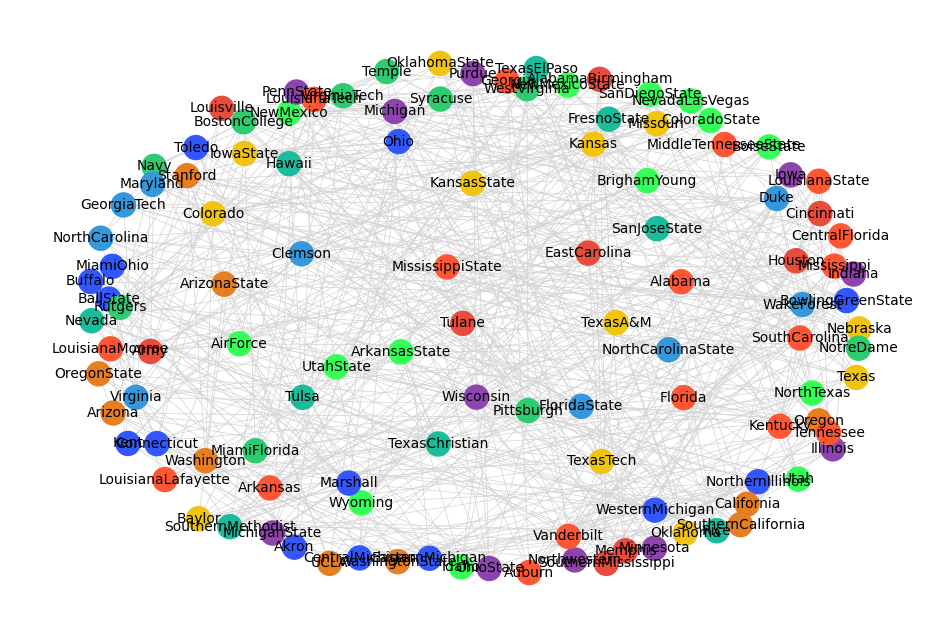

Adjusted Rand Index (ARI): 0.7009
Adjusted Mutual Information (AMI): 0.7974
Homogeneity Score (HS): 0.8396
Completeness Score (CS): 0.8305
F1 Score: 0.1394
Confusion Matrix:
[[ 3  4  0  0  0  0  0  9  0  0]
 [ 1  1  0  0  0  0  8  0  0  8]
 [ 0  0  0  0 11  0  0  0  0  0]
 [ 0  0  0 12  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  9  1]
 [ 1  1  1  0  0  0  2  0  0  0]
 [ 0  0 13  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [12  0  0  0  0  0  0  0  0  0]]
Modularity Density: 0.0720
Community Score: 0.1419
Community Fitness: 0.1419
Normalized Mutual Information (NMI): 0.8351


In [13]:
np.random.seed(43)
random.seed(43)

pos = nx.spring_layout(G)
communities = algorithms.louvain(G).communities
community_dict_louvain = {i: community for i, community in enumerate(communities)}


for i, community in enumerate(communities):
    print(f"Community {i + 1}: {community}")

community_list=list(communities)

# Mappa ogni nodo alla sua comunità
node_to_community = {}
for i, community in enumerate(community_list):
    for node in community:
        node_to_community[node] = i


# Aggiungi gli archi tra le comunità se c'è una connessione tra nodi di comunità diverse
for u, v in G.edges():
    comm_u = node_to_community[u]
    comm_v = node_to_community[v]
    if comm_u != comm_v:
        community_graph.add_edge(comm_u, comm_v)

colors = ["#FF5733",  "#33FF57", "#3357FF", "#F1C40F","#8E44AD", "#E67E22", "#2ECC71", "#3498DB", "#E74C3C", "#1ABC9C", "#9B59B6", "#F39C12"]

color_map_b = {}
keys = G.nodes()
values = "black"
for i in keys:
        color_map_b[i] = values
counter = 0
for c in community_list:
  for n in c:
    color_map_b[n] = colors[counter]
  counter = counter + 1

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=2)
nx.draw_networkx_edges(G, pos, width=0.5, edge_color='lightgray')  # Aumenta la larghezza degli archi
nx.draw_networkx_nodes(G, pos, node_color=[color_map_b[node] for node in G.nodes()])
nx.draw_networkx_labels(G, pos, font_size=10)  # Riduci la dimensione delle etichette
plt.axis("off")
plt.show()


# Definisci le comunità attese come un dizionario
ground_truth_communities = {
    'Comunita_0': ['FloridaState', 'NorthCarolinaState', 'Virginia', 'GeorgiaTech', 'Duke', 'NorthCarolina', 'Clemson', 'WakeForest', 'Maryland'],
    'Comunita_1': ['VirginiaTech', 'BostonCollege', 'WestVirginia', 'Syracuse', 'Pittsburgh', 'Temple', 'Rutgers', 'MiamiFlorida'],
    'Comunita_2': ['Iowa', 'PennState', 'Northwestern', 'Wisconsin', 'Michigan', 'Purdue', 'OhioState', 'Minnesota', 'Illinois', 'MichiganState', 'Indiana'],
    'Comunita_3': ['KansasState', 'TexasTech', 'Baylor', 'Colorado', 'Kansas', 'IowaState', 'Nebraska', 'TexasA&M', 'Oklahoma', 'Texas', 'Missouri', 'OklahomaState'],
    'Comunita_4': ['EastCarolina', 'Houston', 'Louisville', 'Memphis', 'SouthernMississippi', 'Tulane', 'Army', 'Cincinnati', 'TexasChristian', 'AlabamaBirmingham'],
    'Comunita_5': ['CentralFlorida', 'Connecticut', 'Navy', 'NotreDame', 'UtahState'],
    'Comunita_6': ['NorthernIllinois', 'WesternMichigan', 'Akron', 'BallState', 'BowlingGreenState', 'Buffalo', 'CentralMichigan', 'EasternMichigan', 'Kent', 'MiamiOhio', 'Ohio', 'Toledo', 'Marshall'],
    'Comunita_7': ['BrighamYoung', 'NewMexico', 'SanDiegoState', 'Wyoming', 'Utah', 'ColoradoState', 'AirForce', 'NevadaLasVegas'],
    'Comunita_8': ['SouthernCalifornia', 'ArizonaState', 'UCLA', 'Arizona', 'Washington', 'Oregon', 'Stanford', 'WashingtonState', 'OregonState', 'California'],
    'Comunita_9': ['Auburn', 'Alabama', 'Florida', 'Kentucky', 'Vanderbilt', 'MississippiState', 'SouthCarolina', 'Tennessee', 'Mississippi', 'Georgia', 'LouisianaState', 'Arkansas'],
    'Comunita_10': ['NorthTexas', 'ArkansasState', 'Idaho', 'LouisianaMonroe', 'MiddleTennesseeState', 'NewMexicoState', 'LouisianaLafayette'],
    'Comunita_11': ['BoiseState', 'FresnoState', 'Rice', 'SouthernMethodist', 'LouisianaTech', 'Nevada', 'SanJoseState', 'TexasElPaso', 'Tulsa', 'Hawaii']

}

# Calcola le metriche
adj_matrix_full = nx.adjacency_matrix(G).todense()
risultati_louvain = calcola_metriche(ground_truth_communities, community_dict_louvain, adj_matrix_full)

# Leiden

Community 1: ['Auburn', 'Alabama', 'Florida', 'Kentucky', 'LouisianaTech', 'LouisianaMonroe', 'Vanderbilt', 'MiddleTennesseeState', 'MississippiState', 'SouthCarolina', 'Tennessee', 'Mississippi', 'Georgia', 'LouisianaState', 'LouisianaLafayette', 'Arkansas']
Community 2: ['NorthernIllinois', 'WesternMichigan', 'Akron', 'BallState', 'BowlingGreenState', 'Buffalo', 'CentralFlorida', 'CentralMichigan', 'Connecticut', 'EasternMichigan', 'Kent', 'MiamiOhio', 'Ohio', 'Toledo', 'Marshall']
Community 3: ['BrighamYoung', 'NewMexico', 'SanDiegoState', 'NorthTexas', 'Wyoming', 'Utah', 'ArkansasState', 'BoiseState', 'ColoradoState', 'Idaho', 'NewMexicoState', 'UtahState', 'AirForce', 'NevadaLasVegas']
Community 4: ['KansasState', 'TexasTech', 'Baylor', 'Colorado', 'Kansas', 'IowaState', 'Nebraska', 'TexasA&M', 'Oklahoma', 'Texas', 'Missouri', 'OklahomaState']
Community 5: ['Iowa', 'PennState', 'Northwestern', 'Wisconsin', 'Michigan', 'Purdue', 'OhioState', 'Minnesota', 'Illinois', 'MichiganState'

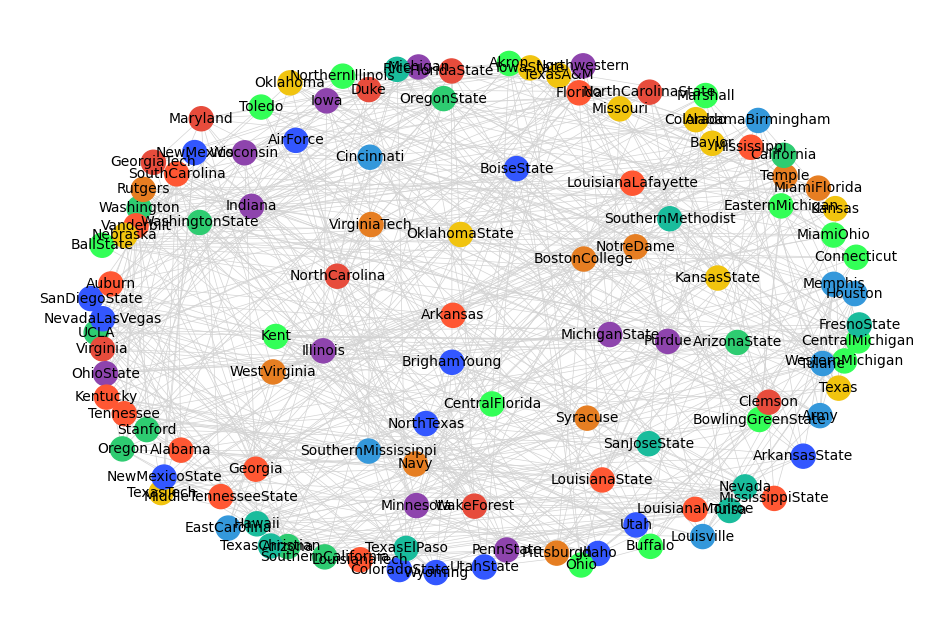

Adjusted Rand Index (ARI): 0.7039
Adjusted Mutual Information (AMI): 0.8043
Homogeneity Score (HS): 0.8455
Completeness Score (CS): 0.8359
F1 Score: 0.1420
Confusion Matrix:
[[ 3  0  4  0  0  0  0  0  9  0]
 [ 1  0  1  0  0  8  0  0  0  8]
 [ 0  0  0  0 11  0  0  0  0  0]
 [ 0  0  0 12  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  9  0  1]
 [ 0  2  1  0  0  2  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0]
 [ 0  0  8  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [12  0  0  0  0  0  0  0  0  0]]
Modularity Density: 0.0718
Community Score: 0.1419
Community Fitness: 0.1419
Normalized Mutual Information (NMI): 0.8407


In [14]:
np.random.seed(43)
random.seed(43)

pos = nx.spring_layout(G)

communities = algorithms.leiden(G).communities
community_dict_leiden = {i: community for i, community in enumerate(communities)}

for i, community in enumerate(communities):
    print(f"Community {i + 1}: {community}")

community_list=list(communities)

# Mappa ogni nodo alla sua comunità
node_to_community = {}
for i, community in enumerate(community_list):
    for node in community:
        node_to_community[node] = i


# Aggiungi gli archi tra le comunità se c'è una connessione tra nodi di comunità diverse
for u, v in G.edges():
    comm_u = node_to_community[u]
    comm_v = node_to_community[v]
    if comm_u != comm_v:
        community_graph.add_edge(comm_u, comm_v)

colors = ["#FF5733",  "#33FF57", "#3357FF", "#F1C40F","#8E44AD", "#E67E22", "#2ECC71", "#3498DB", "#E74C3C", "#1ABC9C", "#9B59B6", "#F39C12"]

color_map_b = {}
keys = G.nodes()
values = "black"
for i in keys:
        color_map_b[i] = values
counter = 0
for c in community_list:
  for n in c:
    color_map_b[n] = colors[counter]
  counter = counter + 1

# Disegna il grafo
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=2)
nx.draw_networkx_edges(G, pos, width=0.5, edge_color='lightgray')  # Aumenta la larghezza degli archi
nx.draw_networkx_nodes(G, pos, node_color=[color_map_b[node] for node in G.nodes()])
nx.draw_networkx_labels(G, pos, font_size=10)  # Riduci la dimensione delle etichette
plt.axis("off")
plt.show()

# Definisci le comunità attese come un dizionario
ground_truth_communities = {
    'Comunita_0': ['FloridaState', 'NorthCarolinaState', 'Virginia', 'GeorgiaTech', 'Duke', 'NorthCarolina', 'Clemson', 'WakeForest', 'Maryland'],
    'Comunita_1': ['VirginiaTech', 'BostonCollege', 'WestVirginia', 'Syracuse', 'Pittsburgh', 'Temple', 'Rutgers', 'MiamiFlorida'],
    'Comunita_2': ['Iowa', 'PennState', 'Northwestern', 'Wisconsin', 'Michigan', 'Purdue', 'OhioState', 'Minnesota', 'Illinois', 'MichiganState', 'Indiana'],
    'Comunita_3': ['KansasState', 'TexasTech', 'Baylor', 'Colorado', 'Kansas', 'IowaState', 'Nebraska', 'TexasA&M', 'Oklahoma', 'Texas', 'Missouri', 'OklahomaState'],
    'Comunita_4': ['EastCarolina', 'Houston', 'Louisville', 'Memphis', 'SouthernMississippi', 'Tulane', 'Army', 'Cincinnati', 'TexasChristian', 'AlabamaBirmingham'],
    'Comunita_5': ['CentralFlorida', 'Connecticut', 'Navy', 'NotreDame', 'UtahState'],
    'Comunita_6': ['NorthernIllinois', 'WesternMichigan', 'Akron', 'BallState', 'BowlingGreenState', 'Buffalo', 'CentralMichigan', 'EasternMichigan', 'Kent', 'MiamiOhio', 'Ohio', 'Toledo', 'Marshall'],
    'Comunita_7': ['BrighamYoung', 'NewMexico', 'SanDiegoState', 'Wyoming', 'Utah', 'ColoradoState', 'AirForce', 'NevadaLasVegas'],
    'Comunita_8': ['SouthernCalifornia', 'ArizonaState', 'UCLA', 'Arizona', 'Washington', 'Oregon', 'Stanford', 'WashingtonState', 'OregonState', 'California'],
    'Comunita_9': ['Auburn', 'Alabama', 'Florida', 'Kentucky', 'Vanderbilt', 'MississippiState', 'SouthCarolina', 'Tennessee', 'Mississippi', 'Georgia', 'LouisianaState', 'Arkansas'],
    'Comunita_10': ['NorthTexas', 'ArkansasState', 'Idaho', 'LouisianaMonroe', 'MiddleTennesseeState', 'NewMexicoState', 'LouisianaLafayette'],
    'Comunita_11': ['BoiseState', 'FresnoState', 'Rice', 'SouthernMethodist', 'LouisianaTech', 'Nevada', 'SanJoseState', 'TexasElPaso', 'Tulsa', 'Hawaii']

}

#Calcola le metriche
adj_matrix_full = nx.adjacency_matrix(G).todense()
risultati_leiden = calcola_metriche(ground_truth_communities, community_dict_leiden, adj_matrix_full)


# Conga

Communities detected:
Communità 1: ['Iowa', 'NorthernIllinois', 'WesternMichigan', 'BallState', 'BowlingGreenState', 'Michigan', 'Buffalo', 'Syracuse', 'Purdue', 'Kent', 'Pittsburgh', 'Minnesota', 'MiamiOhio', 'Ohio', 'Toledo', 'NorthCarolina', 'Marshall', 'MichiganState', 'Missouri', 'NotreDame', 'CentralMichigan', 'PennState', 'Illinois', 'Wisconsin', 'OhioState', 'KansasState', 'IowaState', 'Nebraska', 'Cincinnati', 'Indiana', 'Northwestern', 'Connecticut', 'EasternMichigan', 'Akron']
Communità 2: ['BrighamYoung', 'ArizonaState', 'SanDiegoState', 'Arizona', 'Utah', 'Colorado', 'ColoradoState', 'OhioState', 'Idaho', 'Washington', 'Illinois', 'Oregon', 'Stanford', 'OregonState', 'California', 'AirForce', 'NevadaLasVegas', 'UCLA', 'SouthernCalifornia', 'Nevada', 'FresnoState', 'Wyoming', 'NewMexico', 'UtahState', 'WashingtonState']
Communità 3: ['Northwestern', 'Auburn', 'Florida', 'CentralFlorida', 'GeorgiaTech', 'LouisianaTech', 'LouisianaMonroe', 'MississippiState', 'NewMexicoState'

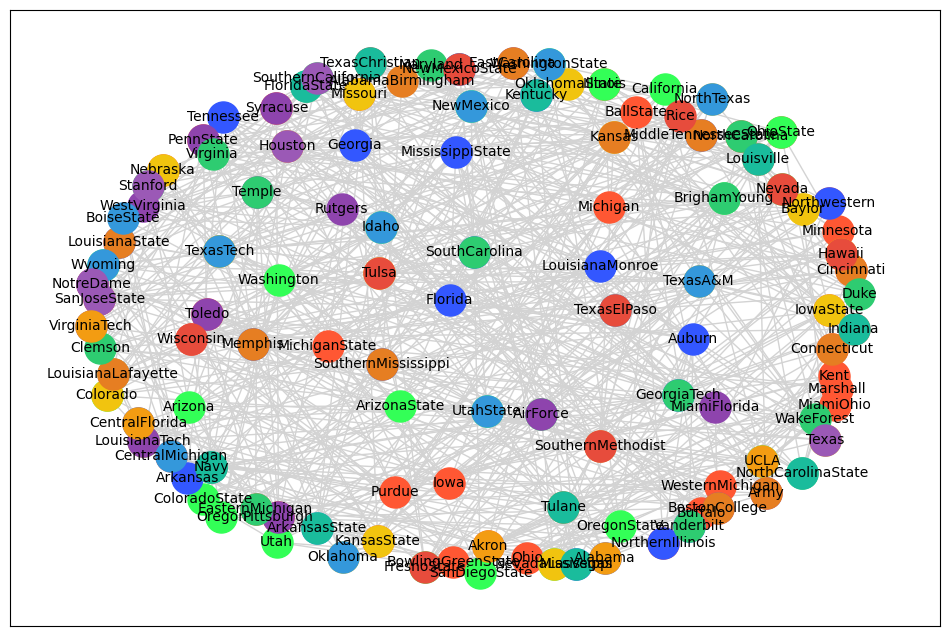

In [15]:
# Run the CONGA algorithm
com = algorithms.conga(G, number_communities=12)
community_dict = {i: community for i, community in enumerate(com.communities)}

# Print the detected communities
print("Communities detected:")
for i, community in enumerate(com.communities):
    print(f"Communità {i + 1}: {community}")

# Prepare for visualization
pos = nx.spring_layout(G, k=2)  # Layout for the nodes
colors = ["#FF5733",  "#33FF57", "#3357FF", "#F1C40F","#8E44AD", "#E67E22", "#2ECC71", "#3498DB", "#E74C3C", "#1ABC9C", "#9B59B6", "#F39C12"]

# Draw the graph with community coloring
plt.figure(figsize=(12, 8))
for community, color in zip(com.communities, colors):
    nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=color, label=f"Community {com.communities.index(community) + 1}", node_size=500)

# Draw the edges
nx.draw_networkx_edges(G, pos, alpha=1, edge_color='lightgray')
nx.draw_networkx_labels(G, pos, font_size=10)  # Dimensione ridotta delle etichette


# Definisci le comunità attese come un dizionario
ground_truth_communities = {
    'Comunita_0': ['FloridaState', 'NorthCarolinaState', 'Virginia', 'GeorgiaTech', 'Duke', 'NorthCarolina', 'Clemson', 'WakeForest', 'Maryland'],
    'Comunita_1': ['VirginiaTech', 'BostonCollege', 'WestVirginia', 'Syracuse', 'Pittsburgh', 'Temple', 'Rutgers', 'MiamiFlorida'],
    'Comunita_2': ['Iowa', 'PennState', 'Northwestern', 'Wisconsin', 'Michigan', 'Purdue', 'OhioState', 'Minnesota', 'Illinois', 'MichiganState', 'Indiana'],
    'Comunita_3': ['KansasState', 'TexasTech', 'Baylor', 'Colorado', 'Kansas', 'IowaState', 'Nebraska', 'TexasA&M', 'Oklahoma', 'Texas', 'Missouri', 'OklahomaState'],
    'Comunita_4': ['EastCarolina', 'Houston', 'Louisville', 'Memphis', 'SouthernMississippi', 'Tulane', 'Army', 'Cincinnati', 'TexasChristian', 'AlabamaBirmingham'],
    'Comunita_5': ['CentralFlorida', 'Connecticut', 'Navy', 'NotreDame', 'UtahState'],
    'Comunita_6': ['NorthernIllinois', 'WesternMichigan', 'Akron', 'BallState', 'BowlingGreenState', 'Buffalo', 'CentralMichigan', 'EasternMichigan', 'Kent', 'MiamiOhio', 'Ohio', 'Toledo', 'Marshall'],
    'Comunita_7': ['BrighamYoung', 'NewMexico', 'SanDiegoState', 'Wyoming', 'Utah', 'ColoradoState', 'AirForce', 'NevadaLasVegas'],
    'Comunita_8': ['SouthernCalifornia', 'ArizonaState', 'UCLA', 'Arizona', 'Washington', 'Oregon', 'Stanford', 'WashingtonState', 'OregonState', 'California'],
    'Comunita_9': ['Auburn', 'Alabama', 'Florida', 'Kentucky', 'Vanderbilt', 'MississippiState', 'SouthCarolina', 'Tennessee', 'Mississippi', 'Georgia', 'LouisianaState', 'Arkansas'],
    'Comunita_10': ['NorthTexas', 'ArkansasState', 'Idaho', 'LouisianaMonroe', 'MiddleTennesseeState', 'NewMexicoState', 'LouisianaLafayette'],
    'Comunita_11': ['BoiseState', 'FresnoState', 'Rice', 'SouthernMethodist', 'LouisianaTech', 'Nevada', 'SanJoseState', 'TexasElPaso', 'Tulsa', 'Hawaii']

}

# Calcola le metriche
adj_matrix_full = nx.adjacency_matrix(G).todense()
risultati_conga = calcola_metriche(ground_truth_communities, community_dict, adj_matrix_full)

# Risultati

                    Label Propagation    Louvain     Leiden      Conga
ARI                          0.651490   0.700910   0.703916   0.233261
AMI                          0.774799   0.797416   0.804307   0.324639
HS                           0.837962   0.839644   0.845491   0.490390
CS                           0.802696   0.830509   0.835881   0.450482
F1 Score                     0.034504   0.139427   0.142029   0.130385
Modularity Density           0.072366   0.072002   0.071795   0.049840
Community Score              0.137031   0.141925   0.141925   0.329527
Community Fitness            0.137031   0.141925   0.141925   0.097879
NMI                          0.819950   0.835052   0.840659   0.469590
Numero di Comunità          11.000000  10.000000  10.000000  12.000000


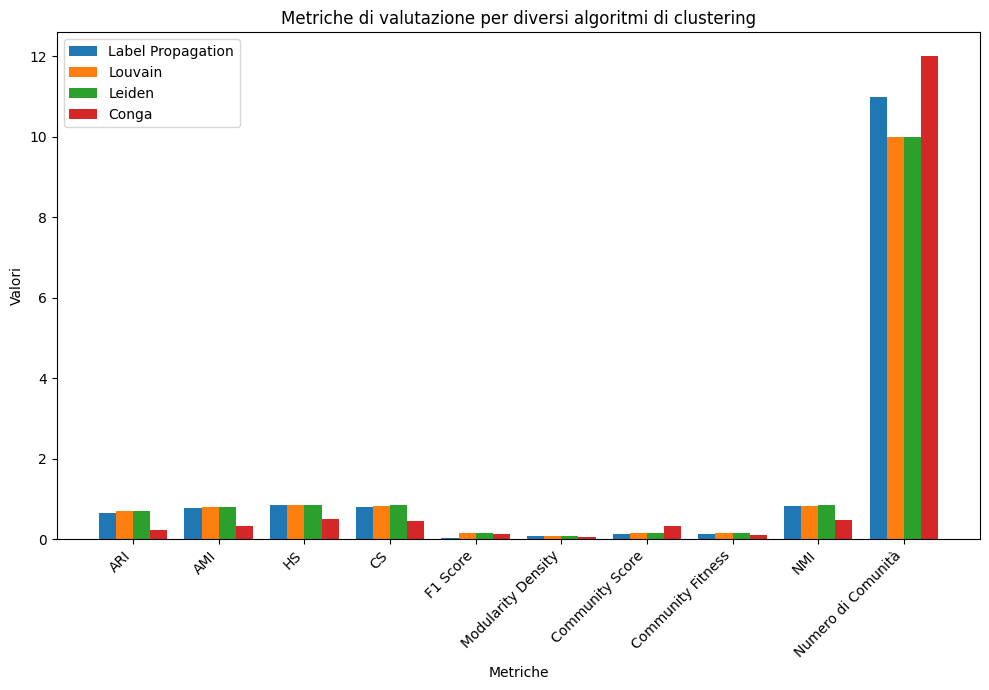

In [16]:
# Aggiungi il numero delle comunità rilevate per ciascun algoritmo nei risultati
risultati = {
    "Label Propagation": {**risultati_label_propagation, "Numero di Comunità": len(community_dict_label_propagation)},
    "Louvain": {**risultati_louvain, "Numero di Comunità": len(community_dict_louvain)},
    "Leiden": {**risultati_leiden, "Numero di Comunità": len(community_dict_leiden)},
    "Conga": {**risultati_conga, "Numero di Comunità": len(community_dict)}
}

# Creazione di un DataFrame dalle metriche ottenute per ogni algoritmo, inclusi il numero di comunità
df_risultati = pd.DataFrame(risultati)

# Visualizzazione del DataFrame per vedere i risultati
print(df_risultati)

# Imposta dimensioni della figura per il grafico
fig, ax = plt.subplots(figsize=(10, 7))

# Definire le posizioni delle barre
n_misure = len(df_risultati.index)
bar_width = 0.2
index = np.arange(n_misure)

# Plot delle barre
for i, algoritmo in enumerate(df_risultati.columns):
    ax.bar(index + i * bar_width, df_risultati[algoritmo], bar_width, label=algoritmo)

# Aggiungere etichette e titolo
ax.set_xlabel('Metriche')
ax.set_ylabel('Valori')
ax.set_title('Metriche di valutazione per diversi algoritmi di clustering')

# Configurazione delle etichette per l'asse X
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels(df_risultati.index, rotation=45, ha='right')

# Aggiungere legenda
ax.legend()

# Mostrare il grafico
plt.tight_layout()
plt.show()
